# 02: Anomaly Detection (Traditional)

This notebook showcases approaches to anomaly detection without deep learning. These can be simpler to manage and understand at the price of being able to handle less complexity.

A challenge here stems from the nature of statistical outliers in package ecosystems; popular, well-structured, and well-documented repositories tend to be anomalous in their success.

Consequently, some feature transformations are needed to push models to instead identify less well-structured packages as anomalies.

> Note on **SourceRank**: This metric is a composite feature used by [libraries.io](https://libraries.io/api#project-sourcerank) to describe the quality of a project based on the presence of metadata, stars/forks, etc.
> 
> Although SourceRank is an opinionated metric and not suitable as a supervised learning target in this context, it is used here as a reference for sanity-checking the resulting anomaly scores.

## **Setup**

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

from data.load import load_and_verify_graph, merge_top_and_recent_graphs

In [2]:
def run_anomaly_model(model_cls, model_params, feature_matrix, score_name, label_name):
    model = model_cls(**model_params)
    model.fit(feature_matrix)

    # Some models use decision_function, some use score_samples
    if hasattr(model, "decision_function"):
        scores = model.decision_function(feature_matrix)
    elif hasattr(model, "score_samples"):
        scores = model.score_samples(feature_matrix)
    else:
        raise AttributeError("Model does not have decision_function or score_samples.")
    
    # Some models use predict, some use fit_predict
    if hasattr(model, "predict"):
        preds = model.predict(feature_matrix)
    else:
        raise AttributeError("Model does not have predict method.")
    
    # -1 == anomaly for sklearn models
    is_anomaly = preds == -1
    return scores, is_anomaly

## **Load Data**

In [3]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME_TOP = "graph_top_n200_20250717"
GRAPH_NAME_RECENT = "graph_recent_n200_20250717"

G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME_TOP, GRAPH_DATA_DIR, print_summary=False)
G_recent, df_edges_recent = load_and_verify_graph(GRAPH_NAME_RECENT, GRAPH_DATA_DIR, print_summary=False)
G_merged = merge_top_and_recent_graphs(G_top, G_recent)

print(f"Number of nodes: {G_merged.number_of_nodes()}")
print(f"Number of edges: {G_merged.number_of_edges()}")

Number of nodes: 1329
Number of edges: 3315


In [4]:
# Base features from the graph nodes, excluding "SourceRank" and some redundant ones
features = [
    "stars", "forks", "contributors", "dependent_projects", "dependent_repositories",
    "subscribers", "num_keywords", "num_optional_deps", "SourceRank",
    "is_deprecated", "is_unmaintained", "is_removed", "is_copycat",
    "any_outdated_dependencies", "is_recent", "all_prereleases",
    "sourcerank_missing", "missing_metadata",
    "has_repo", "has_funding", "core", "basic_info_present", "repository_present",
    "readme_present", "license_present", "versions_present", "recent_release",
    "not_brand_new", "one_point_oh"
]

In [5]:
def prepare_feature_matrix(G, features):
    """
    Prepare input features for anomaly detection models.

    Applies transformations so that well-established repositories are less likely to be flagged as anomalies.
    """
    node_data = [data for _, data in G.nodes(data=True)]
    df = pd.DataFrame(node_data)[features].fillna(0)

    # Positive indicators: more = better established
    positive_features = [
        "stars", "forks", "contributors", "dependent_projects", "dependent_repositories",
        "subscribers", "num_keywords", "num_optional_deps", "SourceRank"
    ]
    for col in positive_features:
        if col in df.columns:
            df[f"{col}_log"] = np.log1p(df[col])

    # Negative indicators: invert so that good repos have HIGH values
    negative_features = [
        "is_deprecated", "is_unmaintained", "is_removed", "is_copycat",
        "any_outdated_dependencies", "is_recent", "all_prereleases",
        "sourcerank_missing", "missing_metadata"
    ]
    for col in negative_features:
        if col in df.columns:
            df[f"{col}_invert"] = 1 - df[col]

    # Binary indicators that are positive if present
    binary_positive_features = [
        "has_repo", "has_funding", "core", "basic_info_present", "repository_present",
        "readme_present", "license_present", "versions_present", "recent_release",
        "not_brand_new", "one_point_oh"
    ]
    for col in binary_positive_features:
        if col in df.columns:
            # Already 1/0, but ensure type and fillna
            df[col] = df[col].fillna(0).astype(int)

    # Create interpretable ratios that are HIGH for well-established repos
    if "forks" in df.columns and "stars" in df.columns:
        df["engagement_ratio"] = np.log1p(df["forks"]) / (np.log1p(df["stars"]) + 0.1)
    if "contributors" in df.columns and "dependent_projects" in df.columns:
        df["maintenance_ratio"] = np.log1p(df["contributors"]) / (np.log1p(df["dependent_projects"]) + 0.1)

    # Select only the transformed features (drop original ones to avoid confusion)
    transformed_cols = [
        col for col in df.columns
        if col.endswith("_log") or col.endswith("_invert")
        or col in ["engagement_ratio", "maintenance_ratio"]
        or col in binary_positive_features
    ]

    return df[transformed_cols], transformed_cols

## **Isolation Forest**

### Algorithm Description

> Simply put, isolation forests recursively split the data and mark observations as more anomalous based on the number of splits required to isolate an observation. While scale-invariant, skewed features may benefit from some transformations (such as stars in this case!)

<img src="../assets/sklearn/sphx_glr_plot_isolation_forest_003.png" alt="Isolation Forest illustration from scikit-learn" width="600"/>

*Isolation Forest example from [scikit-learn's documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)*

In [6]:
def run_and_analyze_detector(
    G, model_cls, model_params, feature_matrix, label, source_rank_key="SourceRank"
):
    scores, labels = run_anomaly_model(model_cls, model_params, feature_matrix, 
                                       score_name=f"anomaly_score_{label}", 
                                       label_name=f"is_anomaly_{label}")
    
    for i, (node, data) in enumerate(G.nodes(data=True)):
        data[f"anomaly_score_{label}"] = scores[i]
        data[f"is_anomaly_{label}"] = labels[i]

    # Print summary
    sr = pd.Series({node: data.get(source_rank_key, None) for node, data in G.nodes(data=True)})
    anomalies = [node for node, data in G.nodes(data=True) if data[f"is_anomaly_{label}"]]
    print(f"\nModel {label}:")
    print(f"  Detected anomalies: {len(anomalies)}")
    print(f"  Avg SourceRank anomalies: {sr[anomalies].mean():.2f}")
    print(f"  Avg SourceRank normal: {sr.drop(anomalies).mean():.2f}")

    df = pd.DataFrame({
        "score": scores,
        "label": labels.astype(int),
        "SourceRank": [data.get(source_rank_key, None) for _, data in G.nodes(data=True)]
    })
    
    return df

feature_matrix, cols = prepare_feature_matrix(G_merged, features)

print(f"Features used ({len(feature_matrix.columns)}): {list(feature_matrix.columns)}")
print(f"Feature matrix shape: {feature_matrix.shape}")

iso_params = {
    "contamination": 0.05, # Proportion of anomalies in the data
    "random_state": 42,
}

df_viz = run_and_analyze_detector(G_merged, IsolationForest, iso_params, feature_matrix, "IsolationForest")

Features used (31): ['has_repo', 'has_funding', 'core', 'basic_info_present', 'repository_present', 'readme_present', 'license_present', 'versions_present', 'recent_release', 'not_brand_new', 'one_point_oh', 'stars_log', 'forks_log', 'contributors_log', 'dependent_projects_log', 'dependent_repositories_log', 'subscribers_log', 'num_keywords_log', 'num_optional_deps_log', 'SourceRank_log', 'is_deprecated_invert', 'is_unmaintained_invert', 'is_removed_invert', 'is_copycat_invert', 'any_outdated_dependencies_invert', 'is_recent_invert', 'all_prereleases_invert', 'sourcerank_missing_invert', 'missing_metadata_invert', 'engagement_ratio', 'maintenance_ratio']
Feature matrix shape: (1329, 31)

Model IsolationForest:
  Detected anomalies: 67
  Avg SourceRank anomalies: 8.45
  Avg SourceRank normal: 16.53


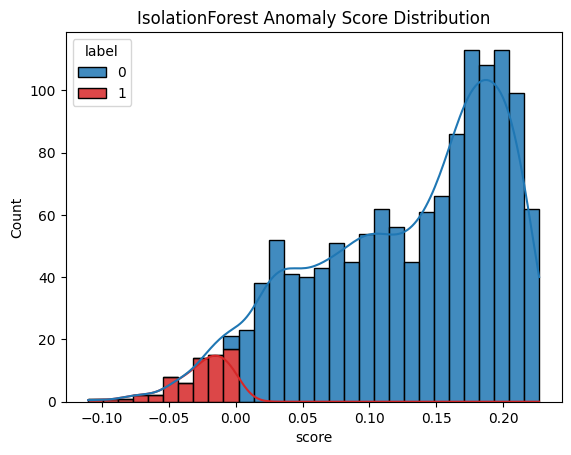

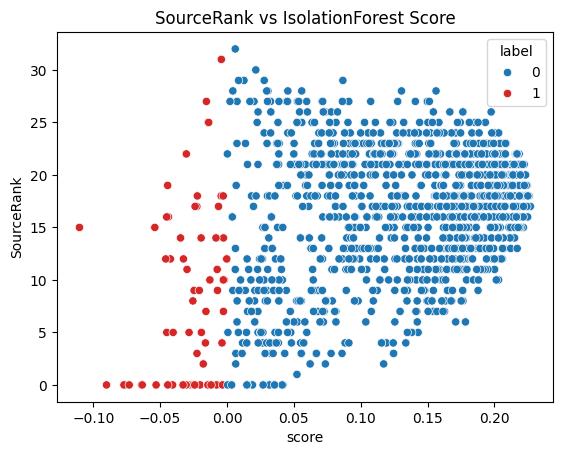

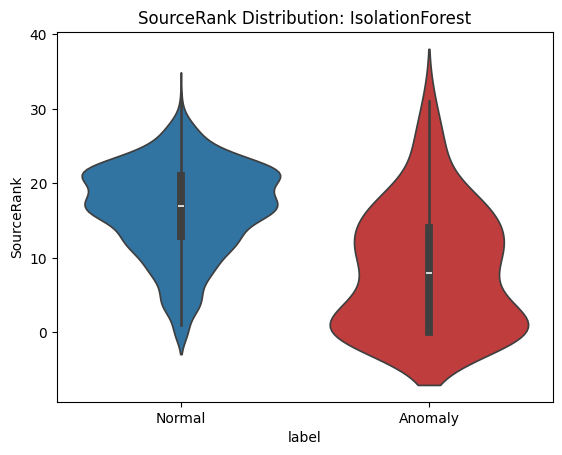

In [7]:
def plot_anomaly_results(df, label):
    palette = {0: "#1f77b4", 1: "#d62728"}
    label_map = {0: "Normal", 1: "Anomaly"}

    # Histogram
    sns.histplot(data=df, x="score", hue="label", bins=30, kde=True,
                 palette=[palette[0], palette[1]], hue_order=[0,1], alpha=0.85, multiple="stack")
    plt.title(f"{label} Anomaly Score Distribution")
    plt.show()

    # Scatterplot SourceRank vs Score
    sns.scatterplot(data=df, x="score", y="SourceRank", hue="label",
                    palette=[palette[0], palette[1]], hue_order=[0,1])
    plt.title(f"SourceRank vs {label} Score")
    plt.show()

    # Violinplot SourceRank per class
    sns.violinplot(data=df, x="label", y="SourceRank", hue="label",
                   palette=[palette[0], palette[1]], order=[0,1], inner="box", legend=False)
    plt.xticks([0,1], [label_map[i] for i in [0,1]])
    plt.title(f"SourceRank Distribution: {label}")
    plt.show()

plot_anomaly_results(df_viz, "IsolationForest")
